## Семинар 6: "Архитектуры и transfer learning"

ФИО:

In [1]:
import numpy as np
from skimage import io, transform
from sklearn.datasets import fetch_mldata
from sklearn.cross_validation import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import MNIST
from torchvision import transforms
from torchvision import models

from tqdm import tqdm

import pandas as pd
import os

%matplotlib inline

/usr/local/lib/python3.5/dist-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


На этом семинаре мы попробуем улучшить результаты, полученные на занятии номер 3 с помощью Transfer Learning

In [2]:
models.AlexNet()

AlexNet (
  (features): Sequential (
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU (inplace)
    (2): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU (inplace)
    (5): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU (inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU (inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU (inplace)
    (12): MaxPool2d (size=(3, 3), stride=(2, 2), dilation=(1, 1))
  )
  (classifier): Sequential (
    (0): Dropout (p = 0.5)
    (1): Linear (9216 -> 4096)
    (2): ReLU (inplace)
    (3): Dropout (p = 0.5)
    (4): Linear (4096 -> 4096)
    (5): ReLU (inplace)
    (6): Linear (4096 -> 1000)
  )
)

In [3]:
class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name).reshape(1, -1)
        landmarks = self.landmarks_frame.iloc[idx, 1:].as_matrix().astype('float')
        landmarks = landmarks.reshape(1, -1)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [4]:
def show_landmarks(image, landmarks, landmarks2):
    """Show image with landmarks"""
    plt.imshow(image, cmap='gray')
    plt.scatter(landmarks[:, 0], landmarks[:, 1], s=10, marker='.', c='r')
    plt.scatter(landmarks2[:, 0], landmarks2[:, 1], s=10, marker='.', c='b')
    plt.pause(0.001)

In [5]:
alex = models.AlexNet().features.cuda()

In [6]:
def show(k, dataset, model, loss_fn):
    item = dataset[k]
    landmarks = item['landmarks'].reshape(-1, 2)
    
    T = torch.from_numpy(item['image'])
    T = T.view(T.size(0), 1, 96, 96).expand(T.size(0), 3, 96, 96)
    T = Variable(T.float().cuda())
    T = alex(T).data.view(T.size(0), -1)
    T = Variable(T).cuda()
    
    y_pred = model(T)
    
    print(loss_fn(y_pred, Variable(torch.from_numpy(landmarks).float().cuda(), requires_grad=False)))
    
    show_landmarks(item['image'].reshape(96, 96), y_pred.data.cpu().numpy().reshape(-1, 2), 
                   landmarks)

In [7]:
def emulate(N, model, optimizer, loss_fn):
    n_epoch = N

    losses = np.zeros(n_epoch)
    test_losses = np.zeros(n_epoch)

    for i in tqdm(range(n_epoch)):
        for batch in train_dataloader:
            X = batch['image']
            y = batch['landmarks']
            
            X = X.view(X.size(0), 1, 96, 96).expand(X.size(0), 3, 96, 96)
            X = Variable(X.float()).cuda()
            X = alex(X).data.view(X.size(0), -1)
            
            X = Variable(X, requires_grad=True).cuda()
            y = Variable(y.float(), requires_grad=False).cuda()
    
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            losses[i] = max(loss.data[0], losses[i])
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    
        for batch in test_dataloader:
            X = batch['image']
            y = batch['landmarks']
        
            X = X.view(X.size(0), 1, 96, 96).expand(X.size(0), 3, 96, 96)
            X = Variable(X.float()).cuda()
            X = alex(X).data.view(X.size(0), -1)
            
            X = Variable(X, requires_grad=True).cuda()
            y = Variable(y.float(), requires_grad=False).cuda()
    
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            test_losses[i] = max(loss.data[0], test_losses[i])
    return losses, test_losses

In [8]:
train_dataset = FaceLandmarksDataset(csv_file='dataset/train/face_landmarks.csv',
                                    root_dir='dataset/train/')
train_dataloader = DataLoader(train_dataset, batch_size=100, num_workers=6)
test_dataset = FaceLandmarksDataset(csv_file='dataset/test/face_landmarks.csv',
                                    root_dir='dataset/test/')
test_dataloader = DataLoader(test_dataset, batch_size=100, num_workers=6)

### Часть 1: Inference

Пропустите картинки с лицами через предобученную на Imagenet "сверточную часть" AlexNet или VGG сетей и обучите на полученных данных один полносвязный слой.

In [9]:
model = nn.Sequential(nn.Linear(1024, 136)).cuda()

loss_fn = nn.MSELoss().cuda()

In [10]:
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.04)

In [13]:
losses, test_losses = emulate(100, model, optimizer, loss_fn)

100%|██████████| 100/100 [03:07<00:00,  1.87s/it]


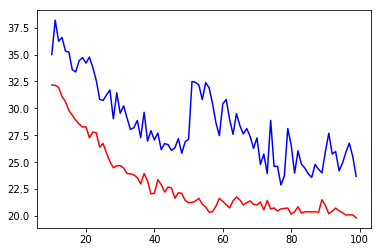

In [14]:
plt.plot([i for i in range(10, len(losses))], losses[10:], c='b')
plt.plot([i for i in range(10, len(losses))], test_losses[10:], c='r')

Variable containing:
 11.7809
[torch.cuda.FloatTensor of size 1 (GPU 0)]



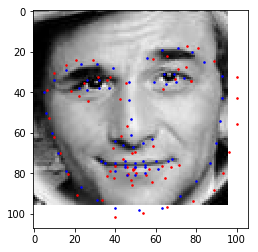

In [16]:
show(1000, train_dataset, model, loss_fn)

Variable containing:
 4.2543
[torch.cuda.FloatTensor of size 1 (GPU 0)]



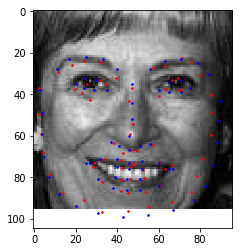

In [17]:
show(2000, train_dataset, model, loss_fn)

Variable containing:
 4.1479
[torch.cuda.FloatTensor of size 1 (GPU 0)]



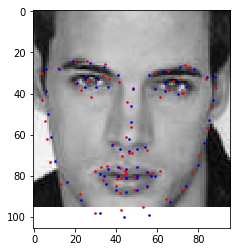

In [18]:
show(1000, test_dataset, model, loss_fn)

Variable containing:
 9.6957
[torch.cuda.FloatTensor of size 1 (GPU 0)]



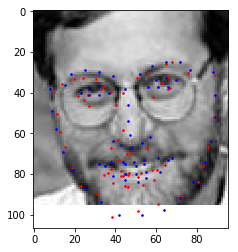

In [19]:
show(1500, test_dataset, model, loss_fn)

### Часть 2 (опциональная)

Попробуйте обучить одну из архитектур на датасете. Сравните результаты с пунктом 1  

In [ ]:
torch.FloatTensor([1.1, 1.2, 1.]).int()

In [ ]:
y.size()

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: